In [2]:
#  Install core packages (quiet mode)
!pip install -q --upgrade transformers accelerate peft bitsandbytes datasets

#  Imports
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer
)
from peft import (
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model
)
from datasets import load_dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 488.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
#  Define model ID
model_id = "HuggingFaceH4/zephyr-7b-beta"

#  4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# LoRA-ready model
model = prepare_model_for_kbit_training(model)

# Sanity check: tokenizer pad token
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [8]:
#  Load Dolly dataset
dataset_id = "databricks/databricks-dolly-15k"
raw_dataset = load_dataset(dataset_id, split="train")

#  Preview structure
print(raw_dataset[0])

{'instruction': 'When did Virgin Australia start operating?', 'context': "Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.", 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.', 'category': 'closed_qa'}


In [10]:
def format_dolly_multiline(example):
    prompt = example["instruction"].strip()
    context = example["context"].strip() if example["context"] else "[No context provided]"
    response = example["response"].strip()

    # Add structure with line separation
    formatted_prompt = f"Instruction:\n{prompt}\n\nContext:\n{context}"
    return {
        "prompt": formatted_prompt,
        "response": response
    }

# 🧪 Apply transformation
formatted_dataset = raw_dataset.map(format_dolly_multiline)

# 🔍 Check a sample
print("Prompt:\n", formatted_dataset[0]["prompt"])
print("\nResponse:\n", formatted_dataset[0]["response"])

Map:   0%|          | 0/15011 [00:00<?, ? examples/s]

Prompt:
 Instruction:
When did Virgin Australia start operating?

Context:
Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.

Response:
 Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.


In [11]:
# Tokenize and measure lengths
def tokenize_and_measure(example):
    prompt_tokens = tokenizer(example["prompt"], truncation=True)["input_ids"]
    response_tokens = tokenizer(example["response"], truncation=True)["input_ids"]
    return {
        "prompt_length": len(prompt_tokens),
        "response_length": len(response_tokens)
    }

#  Apply
token_lengths = formatted_dataset.map(tokenize_and_measure)

#  Inspect stats
prompt_lens = [x["prompt_length"] for x in token_lengths]
response_lens = [x["response_length"] for x in token_lengths]

print(f"Average Prompt Length: {sum(prompt_lens) // len(prompt_lens)} tokens")
print(f"Average Response Length: {sum(response_lens) // len(response_lens)} tokens")

Map:   0%|          | 0/15011 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Average Prompt Length: 121 tokens
Average Response Length: 89 tokens


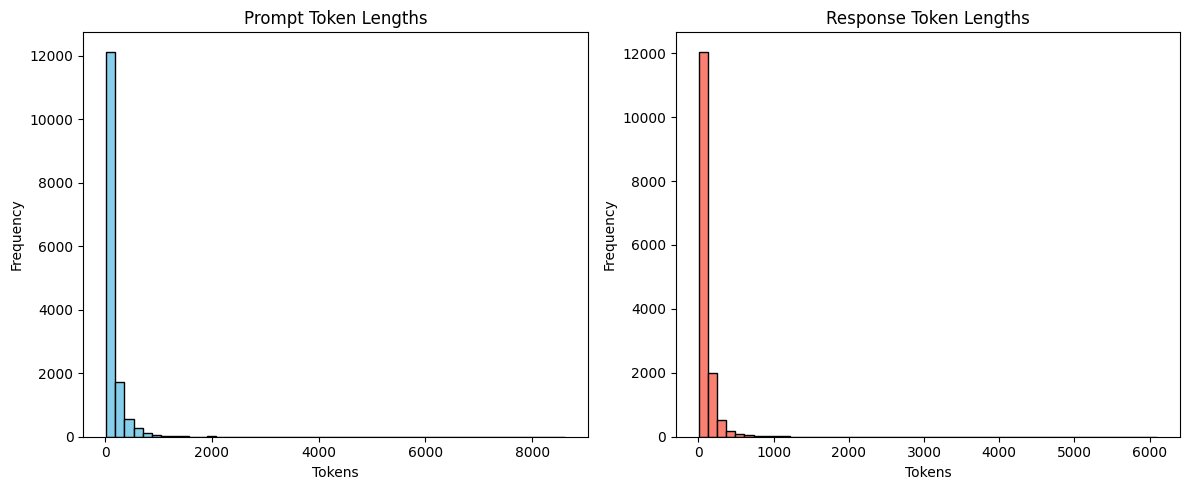

In [12]:
import matplotlib.pyplot as plt

# Create length lists
prompt_lens = [x["prompt_length"] for x in token_lengths]
response_lens = [x["response_length"] for x in token_lengths]

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(prompt_lens, bins=50, color="skyblue", edgecolor="black")
plt.title("Prompt Token Lengths")
plt.xlabel("Tokens")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(response_lens, bins=50, color="salmon", edgecolor="black")
plt.title("Response Token Lengths")
plt.xlabel("Tokens")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

##  Token Length Distribution: Interpretation

The histograms above illustrate the distribution of token lengths for both prompts and responses in the `databricks-dolly-15k` dataset after formatting. Key insights:

- **Prompt Lengths:** The majority of prompts fall below 200 tokens, indicating concise instruction sets. Few prompts exceed 512 tokens, reducing the risk of truncation during training.

- **Response Lengths:** Responses are similarly well-contained, with most under 300 tokens. This is ideal for LoRA-style fine-tuning, ensuring efficient memory usage on Colab.

- **Outliers:** Both distributions show small tails extending beyond typical thresholds. We may want to filter samples exceeding 1024 tokens or having near-zero length for better training stability and faster batching.

Next step: apply a filtering pass to remove outliers or low-value samples.

In [13]:
def length_filter(example):
    prompt_ids = tokenizer(example["prompt"], truncation=True)["input_ids"]
    response_ids = tokenizer(example["response"], truncation=True)["input_ids"]

    prompt_len = len(prompt_ids)
    response_len = len(response_ids)
    total_len = prompt_len + response_len

    return (
        prompt_len >= 30 and
        response_len >= 20 and
        total_len <= 1024
    )

filtered_dataset = formatted_dataset.filter(length_filter)

print(f"Remaining samples: {len(filtered_dataset)}")
print("Sample:\n", filtered_dataset[0])

Filter:   0%|          | 0/15011 [00:00<?, ? examples/s]

Remaining samples: 6357
Sample:
 {'instruction': 'When did Virgin Australia start operating?', 'context': "Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.", 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.', 'category': 'closed_qa', 'prompt': "Instruction:\nWhen did Virgin Australia start operating?\n\nContext:\nVirgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use 

In [14]:
# Define prompt-response joiner
def format_for_training(example):
    full_prompt = example["prompt"]
    full_response = example["response"]

    # Combine with separator and tokenize
    full_text = full_prompt + tokenizer.eos_token + full_response
    tokenized = tokenizer(
        full_text,
        padding="max_length",
        truncation=True,
        max_length=1024,
        return_tensors=None
    )

    # Set labels = input_ids for causal LM
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

# Apply tokenization
tokenized_dataset = filtered_dataset.map(format_for_training, remove_columns=filtered_dataset.column_names)

# Check sample
print(tokenized_dataset[0])

Map:   0%|          | 0/6357 [00:00<?, ? examples/s]

{'input_ids': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

In [19]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4")
model = AutoModelForCausalLM.from_pretrained("HuggingFaceH4/zephyr-7b-beta", quantization_config=bnb_config, device_map="auto")

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [20]:
from peft import LoraConfig, get_peft_model, TaskType

peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()  # Sanity check

trainable params: 6,815,744 || all params: 7,248,547,840 || trainable%: 0.0940


In [21]:
from transformers import TrainingArguments, Trainer

# Training configuration
training_args = TrainingArguments(
    output_dir="./zephyr-lora-output",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    save_total_limit=2,
    eval_strategy="no",  # Change to "steps" if using eval dataset
    report_to="none",          # Avoid using WandB unless needed
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    optim="adamw_torch_fused",
    bf16=True,                 # Use bf16 if supported; fallback to fp16 if not
    gradient_checkpointing=True,
    dataloader_num_workers=2,
    run_name="zephyr-lora-run"
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)

# Optional: sanity check params
print(trainer.args)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=True,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=2,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.NO,
eval_use_gather_object=False,
f

In [23]:
model.enable_input_require_grads()

In [24]:
from peft import get_peft_model, LoraConfig, TaskType

peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:190: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


trainable params: 6,815,744 || all params: 7,248,547,840 || trainable%: 0.0940


In [25]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: requires_grad = {param.requires_grad}")

base_model.model.base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight: requires_grad = True
base_model.model.base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight: requires_grad = True
base_model.model.base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight: requires_grad = True
base_model.model.base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight: requires_grad = True
base_model.model.base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight: requires_grad = True
base_model.model.base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight: requires_grad = True
base_model.model.base_model.model.model.layers.1.self_attn.v_proj.lora_A.default.weight: requires_grad = True
base_model.model.base_model.model.model.layers.1.self_attn.v_proj.lora_B.default.weight: requires_grad = True
base_model.model.base_model.model.model.layers.2.self_attn.q_proj.lora_A.default.weight: requires_grad = True
base_model

In [26]:
trainer.train()

Step,Training Loss


KeyboardInterrupt: 

In [28]:
def format(example):
    text = example["instruction"] + " " + example["input"]
    tokenized = tokenizer(
        text,
        padding="max_length",
        max_length=512,
        truncation=True,
        return_tensors="pt"
    )
    return {
        "input_ids": tokenized["input_ids"][0],
        "attention_mask": tokenized["attention_mask"][0],
        "labels": tokenized["input_ids"][0]  # for causal LM
    }

ds = ds.map(format, remove_columns=ds["train"].column_names, batched=False)

Map:   0%|          | 0/51481 [00:00<?, ? examples/s]

Map:   0%|          | 0/521 [00:00<?, ? examples/s]

In [30]:
def format_batch(batch):
    texts = [f"{instr} {inp}" for instr, inp in zip(batch["instruction"], batch["input"])]
    tokenized = tokenizer(
        texts,
        padding="max_length",
        max_length=512,
        truncation=True
    )
    tokenized["labels"] = tokenized["input_ids"]
    return tokenized

ds = ds.map(format_batch, batched=True, remove_columns=ds["train"].column_names)

Map:   0%|          | 0/51481 [00:00<?, ? examples/s]

Map:   0%|          | 0/521 [00:00<?, ? examples/s]

In [31]:
ds["train"][0]

{'input_ids': [2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  

In [34]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="zephyr-lora-output",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    logging_steps=10,
    save_steps=100,
    eval_steps=100,
    save_total_limit=2,
    fp16=True,
    bf16=False,
    evaluation_strategy="steps",  # 👈 Add this line
    load_best_model_at_end=True,
    report_to="none"
)

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [29]:


#  MODEL LOADING
model_name = "HuggingFaceH4/zephyr-7b-beta"
bnb_config = dict(load_in_4bit=True, bnb_4bit_use_double_quant=True,
                  bnb_4bit_compute_dtype=torch.float16, bnb_4bit_quant_type="nf4")

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", **bnb_config)

#  LO-RA PREP
model = prepare_model_for_kbit_training(model)
peft_config = LoraConfig(
    r=16, lora_alpha=32, lora_dropout=0.05,
    bias="none", task_type="CAUSAL_LM", target_modules=["q_proj", "v_proj"]
)
model = get_peft_model(model, peft_config)

#  DATASET LOADING
ds = load_dataset("tatsu-lab/alpaca", split="train").train_test_split(test_size=0.01)
max_length = 512
ds = ds.map(lambda ex: tokenizer(f"{ex['instruction']} {ex['input']}", truncation=True, max_length=max_length, padding="max_length"), batched=True)

#  TRAINING ARGS
args = TrainingArguments(
    output_dir="zephyr-lora-output",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    logging_steps=10,
    save_steps=100,
    eval_steps=100,
    save_total_limit=2,
    fp16=True,
    bf16=False,
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    report_to="none"
)

# 🚀 TRAINING
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=tokenizer
)
trainer.train()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Map:   0%|          | 0/51481 [00:00<?, ? examples/s]

ArrowInvalid: Column 4 named input_ids expected length 1000 but got length 512